In [1]:
import pylidc as pl
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from inputModule import CTScan
from skimage import io
from multiprocessing import Pool

In [2]:
infomationFilePath = "/storage/huybq/LIDC/"

In [4]:
nodule_count = pd.read_excel(infomationFilePath + "lidc-idri_nodule_count.xlsx")
nodule_count.head()

,TCIA Patent ID,Total Number of Nodules*,Number of Nodules >=3mm**,Number of Nodules <3mm***,Unnamed: 4,Unnamed: 5
0,LIDC-IDRI-0001,4,1,3,NaN,NaN
1,LIDC-IDRI-0002,12,1,11,NaN,*total number of lesions that received either ...
2,LIDC-IDRI-0003,4,4,0,NaN,"**total number of lesions that received a ""nod..."
3,LIDC-IDRI-0004,4,1,3,NaN,"***total number of lesions that received a ""no..."
4,LIDC-IDRI-0005,9,3,6,NaN,NaN


In [5]:
lidc_metadata = pd.read_csv(infomationFilePath + 'LIDC-IDRI_MetaData.csv')
lidc_metadata.head()

,Collection,Patient Id,Study Date,Study Description,Modality,Series Description,Manufacturer,Manufacturer Model,Software Version,Series UID,Unnamed: 10
0,LIDC-IDRI,LIDC-IDRI-0001,01/01/2000,NaN,CT,NaN,GE MEDICAL SYSTEMS,LightSpeed Plus,LightSpeedApps2.4.2_H2.4M5,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,NaN
1,LIDC-IDRI,LIDC-IDRI-0001,01/01/2000,NaN,DX,NaN,GE MEDICAL SYSTEMS,Revolution XQi ADS_28.2,Ads Application Package VERSION ADS_28.2,1.3.6.1.4.1.14519.5.2.1.6279.6001.141365756818...,NaN
2,LIDC-IDRI,LIDC-IDRI-0002,01/01/2000,NaN,CT,NaN,GE MEDICAL SYSTEMS,LightSpeed16,06MW03.5,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,NaN
3,LIDC-IDRI,LIDC-IDRI-0002,01/01/2000,NaN,DX,NaN,GE MEDICAL SYSTEMS,Revolution XRd ADS_27.5.4,Ads Application Package VERSION ADS_27.5.4,1.3.6.1.4.1.14519.5.2.1.6279.6001.493562949900...,NaN
4,LIDC-IDRI,LIDC-IDRI-0003,01/01/2000,NaN,CT,NaN,GE MEDICAL SYSTEMS,LightSpeed16,06MW03.5,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,NaN


In [6]:
nodule_annotation = pd.read_csv(infomationFilePath + 'nodule_annotation.csv')
nodule_annotation.head()

,case,scan,roi,volume,eq. diam.,x loc.,y loc.,slice no.,Unnamed: 8,nodIDs,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,1,3000566,1,6459.75,23.107,317,367,43,NaN,IL057_127364,Nodule 001,MI014_12127,0,NaN,NaN,NaN
1,2,3000522,1,6663.44,23.347,345,361,77,NaN,8,MI014_11691,NaN,NaN,NaN,NaN,NaN
2,3,3000611,1,408.79,9.208,308,198,57,NaN,Nodule 003,IL057_130602,8,MI014_16599,NaN,NaN,NaN
3,3,3000611,2,1165.82,13.058,221,219,56,NaN,IL057_130598,Nodule 002,9,MI014_16595,NaN,NaN,NaN
4,3,3000611,3,4989.64,21.201,367,350,65,NaN,0,IL057_130591,Nodule 001,MI014_16588,NaN,NaN,NaN


In [3]:
def checkState(hUnit):
    if hUnit < -750:
        return 0
    if hUnit >= -750 and hUnit <= -300:
        return 1
    if hUnit > -300 and hUnit < -200:
        return 2
    if hUnit >= -200 and hUnit <= 200:
        return 3
    return 4

In [4]:
def formatPlanes ( dataImg ) :
    formatedData = np.zeros([dataImg.shape[0],dataImg.shape[1]])
    for i in range(dataImg.shape[0]):
        for j in range(dataImg.shape[1]):
            formatedData[i,j] = checkState(dataImg[i,j])
    return formatedData

In [ ]:
'''
    scans are all the scans in the database
    vol is 3D array of the medicalImage
    anns is the annotation of nodule present in [[a1,a2,...][a5,a6,....][]...]
    ann is the array contain the nodule present in [a1,a2,....]
    noduleObj is the a1, that is the annotation of one nodule
'''
metadata_csv = pd.DataFrame(columns=['fileName','subtlety','internalStructure','calcification','sphericity','margin','lobulation','spiculation','texture','malignancy','diameter','surface_area','volume',"avail32","avail64","height","width"])
rerun_name = np.asarray(["1.3.6.1.4.1.14519.5.2.1.6279.6001.149666752178793201786367154542", # wrong resolution
                         "1.3.6.1.4.1.14519.5.2.1.6279.6001.154418190532000744482160157724", # wrong resolution
                         "1.3.6.1.4.1.14519.5.2.1.6279.6001.106068656437895419353734796481", # wrong resolution
                         "1.3.6.1.4.1.14519.5.2.1.6279.6001.233972273372473359632172336060", # wrong resolution
                         "1.3.6.1.4.1.14519.5.2.1.6279.6001.300409677036863686976674785893", # oversize, fit for 128x128
                         "1.3.6.1.4.1.14519.5.2.1.6279.6001.145643207559809787753499447041"])# oversize, fit for 128x128
scans = pl.query(pl.Scan)
for scan in scans:
    currentID = scan.study_instance_uid
    if scan.patient_id == "LIDC-IDRI-0414":
        continue
    anns = scan.cluster_annotations()
    vol = scan.to_volume()
    for i,ann in enumerate(anns):
        noduleObj = ann[0]
        noduleBB = vol[noduleObj.bbox()]
        padding64 = [(math.floor((64.-noduleBB.shape[0])/2),math.ceil((64.-noduleBB.shape[0])/2)),
                   (math.floor((64.-noduleBB.shape[1])/2),math.ceil((64.-noduleBB.shape[1])/2)),
                   (0,0)]
        padding32 = [(math.floor((32.-noduleBB.shape[0])/2),math.ceil((32.-noduleBB.shape[0])/2)),
                   (math.floor((32.-noduleBB.shape[1])/2),math.ceil((32.-noduleBB.shape[1])/2)),
                   (0,0)]
        nodulePatch3D64 = vol[noduleObj.bbox(pad = padding64)]
        nodulePatch3D32 = vol[noduleObj.bbox(pad = padding32)]
        accept32 = accept64 = True
        if nodulePatch3D64.shape[0:2] != (64,64) or noduleBB.shape[0] > nodulePatch3D64.shape[0] or noduleBB.shape[1] > nodulePatch3D64.shape[1]:
            accept64 = False
        if nodulePatch3D32.shape[0:2] != (32,32) or noduleBB.shape[0] > nodulePatch3D32.shape[0] or noduleBB.shape[1] > nodulePatch3D32.shape[1]:
            accept32 = False
        if noduleObj.texture <= 3:
            depth = nodulePatch3D64.shape[2]//2 if nodulePatch3D64.shape[2] > 2 else nodulePatch3D64.shape[2]
            middleSlice = nodulePatch3D64.shape[2]//2
            for curSlice in range (max(middleSlice-depth//2,0), middleSlice+depth//2):
                fileName = f"{currentID}_nodule_{i}_{curSlice}"
#                 if accept64:
#                     nodulePatch2D = nodulePatch3D64[:,:,curSlice]
#                     img_hu = formatPlanes(nodulePatch2D)
#                     img_grey = CTScan.huSegmentation(nodulePatch2D,-800,200)
#                     io.imsave("/storage/huybq/LIDC/lidc_image/grey/grey_64/"+fileName+".png",img_grey,check_contrast=False)
#                     plt.imsave("/storage/huybq/LIDC/lidc_image/heatmap/heatmap_64/"+fileName+".png",img_hu,cmap="afmhot")
#                 if accept32:
#                     nodulePatch2D = nodulePatch3D32[:,:,curSlice]
#                     img_hu = formatPlanes(nodulePatch2D)
#                     img_grey = CTScan.huSegmentation(nodulePatch2D,-800,200)
#                     io.imsave("/storage/huybq/LIDC/lidc_image/grey/grey_32/"+fileName+".png",img_grey,check_contrast=False)
#                     plt.imsave("/storage/huybq/LIDC/lidc_image/heatmap/heatmap_32/"+fileName+".png",img_hu,cmap="afmhot")
                metadata_csv = metadata_csv.append({'fileName':fileName,
                                   'subtlety':noduleObj.subtlety,
                                   'internalStructure':noduleObj.internalStructure,
                                   'calcification':noduleObj.calcification,
                                   'sphericity':noduleObj.sphericity,
                                   'margin':noduleObj.margin,
                                   'lobulation':noduleObj.lobulation,
                                   'spiculation':noduleObj.spiculation,
                                   'texture':noduleObj.texture,
                                   'malignancy':noduleObj.malignancy,
                                   'diameter':noduleObj.diameter,
                                   'surface_area':noduleObj.surface_area,
                                   'volume':noduleObj.volume,
                                   'avail32': accept32,
                                   'avail64': accept64,
                                   'height': noduleBB.shape[0],
                                   'width': noduleBB.shape[1]},ignore_index=True)
        else:
            fileName = f"{currentID}_nodule_{i}"
#             if accept64:
#                 nodulePatch2D = nodulePatch3D64[:,:,nodulePatch3D64.shape[2]//2]
#                 img_hu = formatPlanes(nodulePatch2D)
#                 img_grey = CTScan.huSegmentation(nodulePatch2D,-800,200)
#                 io.imsave("/storage/huybq/LIDC/lidc_image/grey/grey_64/"+fileName+".png",img_grey,check_contrast=False)
#                 plt.imsave("/storage/huybq/LIDC/lidc_image/heatmap/heatmap_64/"+fileName+".png",img_hu,cmap="afmhot")
#             if accept32:
#                 nodulePatch2D = nodulePatch3D32[:,:,nodulePatch3D32.shape[2]//2]
#                 img_hu = formatPlanes(nodulePatch2D)
#                 img_grey = CTScan.huSegmentation(nodulePatch2D,-800,200)
#                 io.imsave("/storage/huybq/LIDC/lidc_image/grey/grey_32/"+fileName+".png",img_grey,check_contrast=False)
#                 plt.imsave("/storage/huybq/LIDC/lidc_image/heatmap/heatmap_32/"+fileName+".png",img_hu,cmap="afmhot")
            metadata_csv = metadata_csv.append({'fileName':fileName,
                               'subtlety':noduleObj.subtlety,
                               'internalStructure':noduleObj.internalStructure,
                               'calcification':noduleObj.calcification,
                               'sphericity':noduleObj.sphericity,
                               'margin':noduleObj.margin,
                               'lobulation':noduleObj.lobulation,
                               'spiculation':noduleObj.spiculation,
                               'texture':noduleObj.texture,
                               'malignancy':noduleObj.malignancy,
                               'diameter':noduleObj.diameter,
                               'surface_area':noduleObj.surface_area,
                               'volume':noduleObj.volume,
                               'avail32': accept32,
                               'avail64': accept64,
                               'height': noduleBB.shape[0],
                               'width': noduleBB.shape[1]},ignore_index=True)
metadata_csv.to_csv('/storage/huybq/LIDC/csvData/metadata.csv',index=False)

In [10]:
scans = pl.query(pl.Scan)
anns = scans[0].cluster_annotations()
anno = anns[0]
anno[0].bbox()

(slice(300, 327, None), slice(318, 346, None), slice(23, 29, None))

In [2]:
metadata = pd.read_csv('/storage/huybq/LIDC/csvData/metadata.csv')
#metadata64 = metadata.drop(metadata.loc[metadata['avail64'] == False].index)
metadata.describe()

,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy,diameter,surface_area,volume,height,width
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000
mean,3.628527,1.021944,5.720690,3.649216,3.590282,1.695611,1.612539,3.979937,2.804389,11.933783,596.925046,957.815750,16.953605,16.975862
std,1.272869,0.250721,0.866819,0.998662,1.372523,1.054703,1.046594,1.462258,1.163619,8.791991,1086.624635,2172.849999,12.078440,12.179708
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.544731,9.744529,6.801801,3.000000,4.000000
25%,3.000000,1.000000,6.000000,3.000000,2.000000,1.000000,1.000000,3.000000,2.000000,6.298639,88.299636,66.901086,9.000000,9.000000
50%,4.000000,1.000000,6.000000,4.000000,4.000000,1.000000,1.000000,5.000000,3.000000,8.462751,162.908377,148.487344,12.000000,12.000000
75%,5.000000,1.000000,6.000000,4.000000,5.000000,2.000000,2.000000,5.000000,3.000000,13.808972,465.686761,550.582409,19.000000,20.000000
max,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,49.944618,9026.567042,31112.197113,67.000000,86.000000


In [3]:
def getName(fullname):
    pos = [index for index,char in enumerate(fullname) if char == '_']
    if len(pos) == 2:
        return fullname
    else:
        return fullname[0:pos[2]]

In [37]:
prevName = ""
count = np.asarray([0,0,0,0,0])
height = []
width = []
for index,row in metadata.iterrows():
    name = getName(row['fileName'])
    if name == prevName:
        continue
    height.append(row['height'])
    width.append(row['width'])
    count[row['texture']-1] = count[row['texture']-1] + 1
    prevName = name

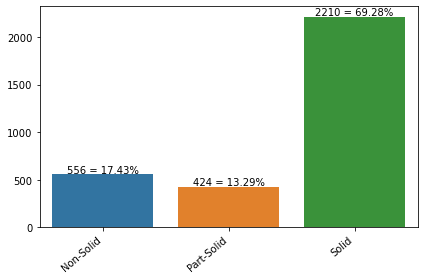

In [15]:
count = np.asarray([count[0]+count[1],count[2],count[3]+count[4]])
#texture = ["Non-Solid/GGO","Non-Solid/Mixed","Part Solid/Mixed","Solid/Mixed","Solid"]
texture = ["Non-Solid","Part-Solid","Solid"]
noduleType = sns.barplot(texture,count)
noduleType.set_xticklabels(noduleType.get_xticklabels(), rotation=40, ha="right")
for index,p in enumerate(noduleType.patches):
    height = p.get_height()
    noduleType.text(p.get_x()+p.get_width()/2.,height + 15,str(count[index])+" = "+str('{:1.2f}'.format(count[index]/count.sum()*100))+"%",ha="center") 
# plt.figure(figsize=(10,20))
plt.tight_layout()
plt.savefig('/storage/huybq/LIDC/figure/dataset-stats-after-sum.png',dpi=360)

In [5]:
class1 = metadata.drop(metadata.loc[metadata['texture'] >=3].index)
class1.describe()

,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy,diameter,surface_area,volume,height,width
count,556.000000,556.000000,556.0,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000
mean,2.392086,1.071942,6.0,3.748201,1.845324,1.654676,1.521583,1.190647,2.895683,13.592096,694.635628,987.469317,19.467626,19.593525
std,1.321019,0.443415,0.0,0.961182,0.866491,1.037754,0.897184,0.393165,0.975326,8.051327,866.901079,1629.735060,11.893705,11.640728
min,1.000000,1.000000,6.0,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.544731,9.744529,9.523026,3.000000,5.000000
25%,1.000000,1.000000,6.0,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,7.106473,95.793869,76.861107,10.000000,11.000000
50%,2.000000,1.000000,6.0,4.000000,2.000000,1.000000,1.000000,1.000000,3.000000,10.940917,289.604202,241.167068,15.000000,16.000000
75%,3.000000,1.000000,6.0,5.000000,2.000000,2.000000,2.000000,1.000000,3.000000,18.342761,945.315937,1298.620533,26.000000,26.000000
max,5.000000,4.000000,6.0,5.000000,5.000000,5.000000,5.000000,2.000000,5.000000,36.440712,3331.497131,7967.346712,55.000000,54.000000


<AxesSubplot:>

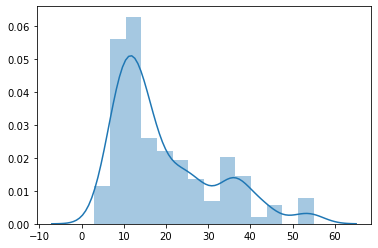

In [6]:
sns.distplot(class1['height'].to_numpy())#,hist_kws={'cumulative': True})

<AxesSubplot:>

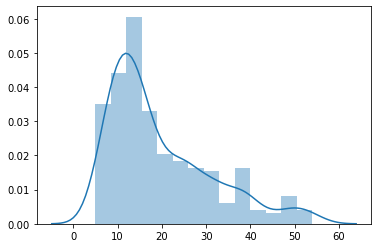

In [23]:
sns.distplot(class1['width'].to_numpy())#,hist_kws={'cumulative': True})

<AxesSubplot:>

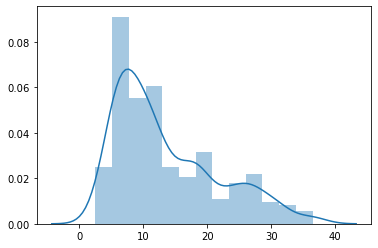

In [24]:
sns.distplot(class1['diameter'].to_numpy())#,hist_kws={'cumulative': True})

In [25]:
class2 = metadata.drop(metadata.loc[metadata['texture'] != 3].index)
class2.describe()

,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy,diameter,surface_area,volume,height,width
count,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.0,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000
mean,3.943396,1.014151,5.981132,3.023585,2.429245,2.334906,2.306604,3.0,3.537736,19.463558,1590.050108,2489.740842,27.283019,27.787736
std,1.173628,0.205797,0.216621,0.904107,1.138077,1.277597,1.324565,0.0,1.184410,13.197061,1998.642082,3277.821241,17.638747,18.132354
min,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,3.0,1.000000,3.587400,24.631152,14.132648,6.000000,6.000000
25%,3.000000,1.000000,6.000000,2.000000,2.000000,1.000000,1.000000,3.0,3.000000,7.969556,145.480535,128.219604,12.000000,12.000000
50%,4.000000,1.000000,6.000000,3.000000,2.000000,2.000000,2.000000,3.0,3.000000,14.015781,436.148012,457.397461,21.000000,21.000000
75%,5.000000,1.000000,6.000000,4.000000,3.000000,3.000000,3.000000,3.0,5.000000,30.994681,2700.436597,3785.705566,42.000000,45.000000
max,5.000000,4.000000,6.000000,5.000000,5.000000,5.000000,5.000000,3.0,5.000000,43.372448,7399.082505,11168.454991,61.000000,67.000000


<AxesSubplot:>

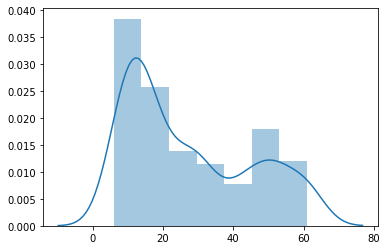

In [26]:
sns.distplot(class2['height'].to_numpy())#,hist_kws={'cumulative': True})

<AxesSubplot:>

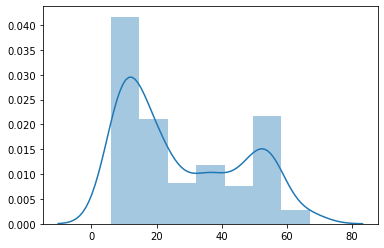

In [27]:
sns.distplot(class2['width'].to_numpy())#,hist_kws={'cumulative': True})

<AxesSubplot:>

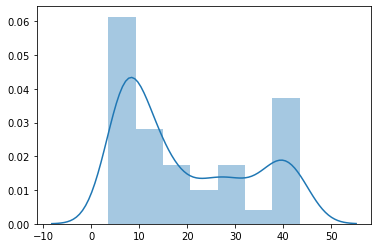

In [28]:
sns.distplot(class2['diameter'].to_numpy())#,hist_kws={'cumulative': True})

In [29]:
class3 = metadata.drop(metadata.loc[metadata['texture'] <= 3].index)
class3.describe()

,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy,diameter,surface_area,volume,height,width
count,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000
mean,3.879186,1.010860,5.600452,3.744344,4.252036,1.583258,1.502262,4.869683,2.640724,10.071952,381.806444,656.447594,14.339367,14.242986
std,1.081710,0.180211,1.014204,0.982084,0.905347,0.965025,0.967673,0.336728,1.146715,6.849259,716.126669,1884.035651,9.305087,9.247674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,2.585936,12.846863,6.801801,5.000000,4.000000
25%,3.000000,1.000000,6.000000,3.000000,4.000000,1.000000,1.000000,5.000000,2.000000,6.044300,83.167261,62.536158,9.000000,9.000000
50%,4.000000,1.000000,6.000000,4.000000,4.000000,1.000000,1.000000,5.000000,3.000000,7.723331,138.497805,120.617714,11.000000,11.000000
75%,5.000000,1.000000,6.000000,5.000000,5.000000,2.000000,2.000000,5.000000,3.000000,10.889835,295.942673,334.087785,16.000000,16.000000
max,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,49.944618,9026.567042,31112.197113,67.000000,86.000000


<AxesSubplot:>

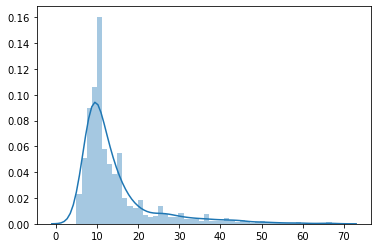

In [30]:
sns.distplot(class3['height'].to_numpy())#,hist_kws={'cumulative': True})

<AxesSubplot:>

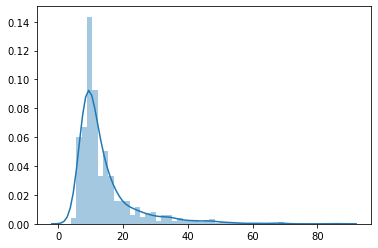

In [31]:
sns.distplot(class3['width'].to_numpy())#,hist_kws={'cumulative': True})

<AxesSubplot:>

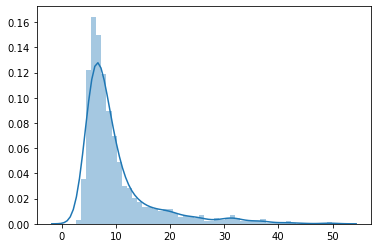

In [32]:
sns.distplot(class3['diameter'].to_numpy())#,hist_kws={'cumulative': True})

In [22]:
#voxel_height_cdf = sns.distplot(height)#,hist_kws={'cumulative': True})
# for p in voxel_height_cdf.patches:
#     if round(p.get_x()) == 64:
#         plt.axvline(64, 0,p.get_height())
#         voxel_height_cdf.axhline(p.get_height())
#plt.savefig('/storage/huybq/LIDC/figure/height_dist.png',dpi=360)
height = np.asarray(height)
width = np.asarray(width)
(height < 64).sum()/height.shape[0]

0.998426435877262

In [52]:
#voxel_width_cdf = sns.distplot(width)#,hist_kws={'cumulative': True})
# for p in voxel_width_cdf.patches:
#     if p.get_x() > 64:
#         plt.axvline(64, 0,p.get_height())
#         voxel_width_cdf.axhline(p.get_height())
#plt.savefig('/storage/huybq/LIDC/figure/width_dist.png',dpi=360)

size = [(height[i],width[i]) for i in range(0,len(height))]
size = np.asarray(size)
size = size < 32
size = [size[i][0] and size[i][1] for i in range(0,len(height))]
size = np.asarray(size)
size.sum()/len(height)

0.9150275373721479

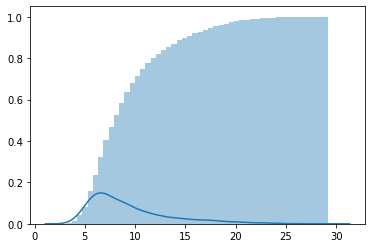

In [17]:
diameter_cdf = sns.distplot(data['diameter'].to_numpy(),hist_kws={'cumulative': True})
# for p in diameter_cdf.patches:
#     if round(p.get_x()) == 3:
#         plt.axvline(3, 0,p.get_height())
#         diameter_cdf.axhline(p.get_height())
#     if round(p.get_x()) == 30:
#         plt.axvline(30, 0,p.get_height())
#         diameter_cdf.axhline(p.get_height())
plt.savefig('/storage/huybq/LIDC/figure/voxel_diameter_reduced_cdf.png')

In [8]:
all_heights = size_invest['voxel_height'].to_numpy()
all_widths = size_invest['voxel_width'].to_numpy()
all_depths = size_invest['voxel_depth'].to_numpy()

print('Height mean:', all_heights.mean(),"Height max:",np.max(all_heights),"Height min:",np.min(all_heights))
print('Width mean:', all_widths.mean(),"Width max:",np.max(all_widths),"Width min:",np.min(all_widths))
print('Depth mean:', all_depths.mean(),"Depth max:",np.max(all_depths),"Depth min:",np.min(all_depths))

Height mean: 15.739244567595158 Height max: 98 Height min: 3
Width mean: 15.62695056147003 Width max: 86 Width min: 4
Depth mean: 5.859267901414613 Depth max: 56 Depth min: 1


In [3]:
metadata = pd.read_csv(infomationFilePath + 'dataset32.csv')
metadata.head()

,fileName,texture
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,5
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,4
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,4
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,5
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.303241414168...,5


In [4]:
metadata.describe()

,texture
count,6215.000000
mean,4.412711
std,1.168076
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6215 entries, 0 to 6214
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fileName  6215 non-null   object
 1   texture   6215 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 97.2+ KB


In [7]:
# def getNodules(scan):
#     currentID = scan.study_instance_uid
#     if scan.patient_id == "LIDC-IDRI-0414":
#         return
#     anns = scan.cluster_annotations()
#     vol = scan.to_volume()
#     for i,ann in enumerate(anns):
#         for j,noduleObj in enumerate(ann):
#             noduleBB = vol[noduleObj.bbox()]
#             padding = [(math.floor((65.-noduleBB.shape[0])/2),math.ceil((65.-noduleBB.shape[0])/2)),
#                        (math.floor((65.-noduleBB.shape[1])/2),math.ceil((65.-noduleBB.shape[1])/2)),
#                        (0,0)]
#             nodulePatch3D = vol[noduleObj.bbox(pad = padding)]
#             nodulePatch2D = nodulePatch3D[:,:,nodulePatch3D.shape[2]//2]
#             img = formatPlanes(nodulePatch2D)
#             plt.imsave(infomationFilePath+"LIDC_heatmap_segmented/"+fileName+".png",img,cmap="RdBu")
# scans = pl.query(pl.Scan)
p = Pool(processes=24)
p.map(getNodules, [(scan) for scan in scans])
p.close()
p.join()